In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

from src.bill_passage.model_analysis_functions import fetch_evaluations_models, fetch_all_evaluations_for_model

In [3]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

**Sponsor Distribution**

In [17]:
q = """
    select bill_id, count(distinct sponsor_id) as num_sponsors from clean_2.bill_sponsors
    group by bill_id
    order by count(*) desc
"""

num_sponsors_bill = pd.read_sql(q, db_conn)

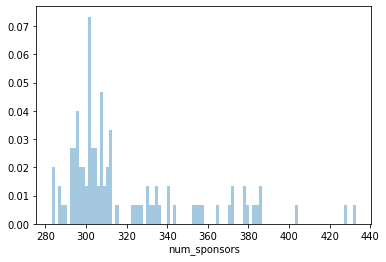

In [19]:
sns.distplot(num_sponsors_bill['num_sponsors'].head(100), kde=False, norm_hist=True, bins=100)

In [20]:
q = """
    with sponsor_bills as (
        select 
            sponsor_id, bill_id, max(case when event=4 then 1 else 0 end) as passed
        from clean_2.bill_sponsors join clean_2.bills using(bill_id) join clean_2.bill_progress using(bill_id)
        where introduced_date < '{as_of_date}' and progress_date < '{as_of_date}'
        group by 1, 2
    )
    select 
        sponsor_id, 
        count(distinct bill_id) as num_bills,
        sum(passed) as num_successful_bills,
        sum(passed)::float / count(distinct bill_id) as success_rate
    from sponsor_bills
    group by sponsor_id
"""

In [21]:
as_of_date = '2018-03-01'
sponsor_success_rates = pd.read_sql(q.format(as_of_date=as_of_date), db_conn)

In [22]:
sponsor_success_rates.head()

,sponsor_id,num_bills,num_successful_bills,success_rate
0,1,216,109,0.504630
1,2,331,91,0.274924
2,3,291,34,0.116838
3,4,63,1,0.015873
4,5,740,225,0.304054
